In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


In [125]:
telecoms_train = pd.read_csv("churn-bigml-80.csv", delimiter=",")
telecoms_test = pd.read_csv("churn-bigml-20.csv", delimiter=",")


<AxesSubplot:>

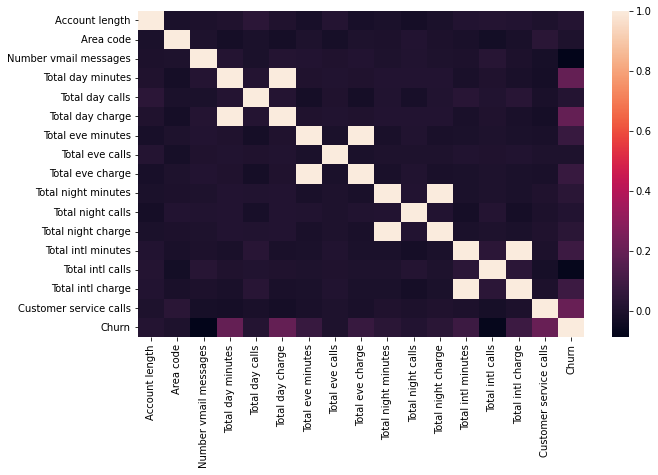

In [126]:
plt.figure(figsize=(10, 6))
sns.heatmap(telecoms_train.corr())


In [127]:
columns_null_values = telecoms_train.isnull().sum(axis=0)
columns_null_values = columns_null_values[columns_null_values > 0]
print(columns_null_values.shape[0])
columns_null_values


0


Series([], dtype: int64)

In [128]:
telecoms_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

In [129]:
telecoms_train.head()


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [130]:
X_train = telecoms_train.drop(["Churn", "State"], axis=1)
y_train = telecoms_train["Churn"]
# y_train = y_train.to_numpy().reshape(y_train.shape[0], 1)


In [131]:
numerical_features = make_column_selector(dtype_include= np.number)
categorical_features = make_column_selector(dtype_exclude= np.number)

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

preprosseor = make_column_transformer((numerical_pipeline, numerical_features),(categorical_pipeline, categorical_features))


In [132]:
# selector = SelectKBest(chi2, k=8)
# X_train_new = preprosseor.fit_transform(X_train, y_train)
# X_train_new = selector.fit_transform(X_train_new, y_train)
# X_train_new


In [133]:
clf_knn = KNeighborsClassifier()
param_grid_knn = {
    # 'selectkbest__k': range(0, X_train.shape[1]),
    # 'selectkbest__score_func': [chi2],
    'kneighborsclassifier__n_neighbors': range(1, 10),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2],
    'kneighborsclassifier__metric': ['minkowski', 'euclidean', 'manhattan'],

}
model_knn = make_pipeline(preprosseor,  clf_knn)
grid_search_knn = GridSearchCV(model_knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)
print(grid_search_knn.best_params_)
print(grid_search_knn.best_score_)


{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 6, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}
0.888225084498036


In [134]:
best_model_knn = grid_search_knn.best_estimator_


In [135]:
clf_dt = DecisionTreeClassifier()
param_grid_dt = {
    # 'selectkbest__k': range(0, X_train.shape[1]),
    # 'selectkbest__score_func': [chi2],
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__splitter': ['best', 'random'],
    'decisiontreeclassifier__max_depth': range(1, 10),
    'decisiontreeclassifier__min_samples_split': range(2, 5),
    'decisiontreeclassifier__min_samples_leaf': range(1, 5),
    'decisiontreeclassifier__max_features': ['auto'],
    'decisiontreeclassifier__random_state': [42],
}
preprosseor_dt = make_column_transformer((categorical_pipeline, categorical_features), remainder='passthrough')
model_dt = make_pipeline(preprosseor,  clf_dt)
grid_search_dt = GridSearchCV(model_dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)
print(grid_search_dt.best_params_)
print(grid_search_dt.best_score_)


{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__max_features': 'auto', 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2, 'decisiontreeclassifier__random_state': 42, 'decisiontreeclassifier__splitter': 'best'}
0.9272340156417986


In [136]:
best_model_dt = grid_search_dt.best_estimator_


In [137]:
clf_rf = RandomForestClassifier()
param_grid_rf = {
    # 'selectkbest__k': range(0, X_train.shape[1]),
    # 'selectkbest__score_func': [chi2],
    'randomforestclassifier__n_estimators': range(1, 10),
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': range(1, 10),
    'randomforestclassifier__min_samples_split': range(2, 5),
    'randomforestclassifier__min_samples_leaf': range(1, 5),
    'randomforestclassifier__max_features': ['auto'],
    'randomforestclassifier__random_state': [42],
}
model_rf = make_pipeline(preprosseor,  clf_rf)
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)


{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 9, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 7, 'randomforestclassifier__random_state': 42}
0.945987309484158


In [138]:
best_model_rf = grid_search_rf.best_estimator_

In [139]:
X_test = telecoms_test.drop(["Churn"], axis=1)
y_test = telecoms_test["Churn"]
y_test = y_test.reshape(y_test.shape[0], 1)


AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
y_pred_knn = best_model_knn.predict(X_test)
y_pred_dt = best_model_dt.predict(X_test)
y_pred_rf = best_model_rf.predict(X_test)

In [ ]:
print("KNN:")
print(classification_report(y_test, y_pred_knn))


KNN:
              precision    recall  f1-score   support

       False       0.90      0.98      0.94       572
        True       0.71      0.36      0.48        95

    accuracy                           0.89       667
   macro avg       0.80      0.67      0.71       667
weighted avg       0.87      0.89      0.87       667



In [ ]:
print("DT:")
print(classification_report(y_test, y_pred_dt))



DT:
              precision    recall  f1-score   support

       False       0.89      0.97      0.93       572
        True       0.61      0.32      0.42        95

    accuracy                           0.87       667
   macro avg       0.75      0.64      0.67       667
weighted avg       0.85      0.87      0.86       667



In [ ]:
print("RF:")
print(classification_report(y_test, y_pred_rf))


RF:
              precision    recall  f1-score   support

       False       0.91      0.99      0.95       572
        True       0.91      0.42      0.58        95

    accuracy                           0.91       667
   macro avg       0.91      0.71      0.76       667
weighted avg       0.91      0.91      0.90       667

